### Introduction

The data mining task for this model comparison is to classify data based on the category it was originally extracted from Google.



In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import string
import re
from nltk.stem import PorterStemmer
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display
from matplotlib import rcParams

%matplotlib inline

In [47]:
plt.rcParams["figure.figsize"] = (16,9)

In [30]:
data = pd.read_json("noticias_vzla_combined.json")
data['category_id'] = data['category'].factorize()[0]

In [31]:
data.sample(20)

,fecha,strategy,texto,title,url,category,texto_tokenized,texto_nonstop,texto_stemmed,texto_lemmatized,texto_punct,sentiment,category_id
739,17/07/2717,2,"Martes, 11 de diciembre de 2018\nSalida de emp...",Hoy se publica el especial sobre el modelo fal...,https://www.larepublica.co/globoeconomia/hoy-s...,economia,"[martes, 11, de, diciembre, de, 2018, salida, ...","[martes, 11, diciembre, 2018, salida, empresas...","[mart, 11, diciembr, 2018, salida, empresa, hi...","[martes, 11, diciembre, 2018, salida, empresas...",Martes de diciembre de \nSalida de empresas e...,-0.7783,2
180,None,2,"A finales de julio de 2018, estimó la Asamblea...",Hambre pavorosa en Venezuela,https://www.elespectador.com/opinion/hambre-pa...,hambre,"[a, finales, de, julio, de, 2018, estimó, la, ...","[finales, julio, 2018, estimó, asamblea, nacio...","[final, julio, 2018, estimó, asamblea, nacion,...","[finale, julio, 2018, estimó, asamblea, nacion...",A finales de julio de estimó la Asamblea Naci...,-0.9460,0
218,2018-03-01T09:40:32Z,1,,Hasta los animales se mueren de hambre en los ...,https://www.abc.es/internacional/abci-hasta-an...,hambre,[],[],[],[],,0.0000,0
126,01/12/2018,2,"MADRID, 1 Dic. (EUROPA PRESS) -\nLa crisis de ...",Acción contra el Hambre lamenta la falta de at...,https://www.notimerica.com/politica/noticia-ac...,hambre,"[madrid, 1, dic, europa, press, la, crisis, de...","[madrid, 1, dic, europa, press, crisis, corre,...","[madrid, 1, dic, europa, press, crisi, corr, r...","[madrid, 1, dic, europa, press, crisis, corre,...",MADRID Dic EUROPA PRESS \nLa crisis de Venezu...,0.9118,0
846,,1,Dice que aumentará la capacidad adquisitiva de...,Este es el plan de Guaidó para reactivar la ec...,https://www.portafolio.co/internacional/juan-g...,economia,"[dice, que, aumentará, la, capacidad, adquisit...","[dice, aumentará, capacidad, adquisitiva, vene...","[dice, aumentará, capacidad, adquisitiva, vene...","[dice, aumentará, capacidad, adquisitiva, vene...",Dice que aumentará la capacidad adquisitiva de...,0.3400,2
557,12/06/0000,2,Comparte esta actualización en\nEstos son vínc...,Crisis en Venezuela: qué medios tiene para res...,https://www.bbc.com/mundo/noticias-america-lat...,economia,"[comparte, esta, actualización, en, estos, son...","[comparte, actualización, vínculos, páginas, e...","[compart, actualización, vínculo, página, exte...","[comparte, actualización, vínculos, páginas, e...",Comparte esta actualización en\nEstos son vínc...,-0.9465,2
543,None,2,Aunque en medio de las sanciones Nicolás Madur...,Maduro ahorca la economía venezolana en su emp...,https://alnavio.com/noticia/17409/actualidad/m...,economia,"[aunque, en, medio, de, las, sanciones, nicolá...","[aunque, medio, sanciones, nicolás, maduro, bu...","[aunqu, medio, sancion, nicolá, maduro, buscad...","[aunque, medio, sanciones, nicolás, maduro, bu...",Aunque en medio de las sanciones Nicolás Madur...,-0.9382,2
521,2019-02-20,1,"Juan Guaidó, presidente encargado de Venezuela...",El futuro de Venezuela se decide el 23-F: los ...,https://www.elespanol.com/mundo/20190220/futur...,represion,"[juan, guaidó, presidente, encargado, de, vene...","[juan, guaidó, presidente, encargado, reuters,...","[juan, guaidó, president, encargado, reuter, p...","[juan, guaidó, presidente, encargado, reuters,...",Juan Guaidó presidente encargado de Venezuela\...,-0.9295,1
208,05/09/2018,2,La bancada de diputados de Acción Democrática ...,Diputados de AD presentan plan contra el hambr...,http://www.ntn24.com/america-latina/venezuela/...,hambre,"[la, bancada, de, diputados, de, acción, democ...","[bancada, diputados, acción, democrática, ad, ...","[bancada, diputado, acción, democrática, ad, a...","[bancada, diputados, acción, democrática, ad, ...",La bancada de diputados de Acción Democrática ...,-0.9652,0
416,None,2,La crisis económica y la represión a medios si...,"Nicaragua, rumbo a convertirse en una 'segunda...",https://www.eltiempo.com/mundo/latinoamerica/a...,represion,"[la, crisis, económica, y,

Balanceo de clases a predecir

Hay entre 250 a 350 documentos por clase

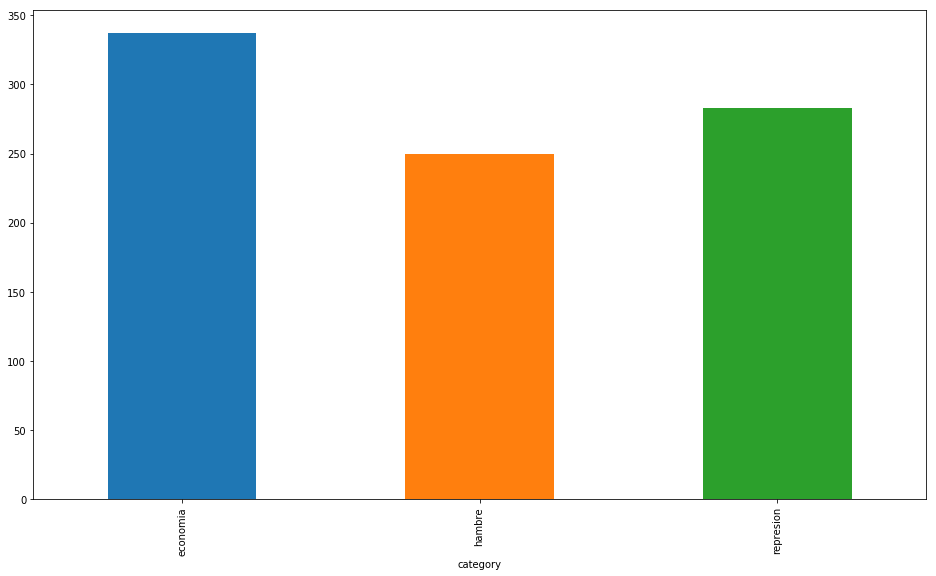

In [48]:
data.groupby('category').sentiment.count().plot.bar(ylim=0)

Algunos mappings útiles para mostrar gráficos con títulos relevantes

In [33]:
category_id_df = data[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

Algunas stopwords utilizadas en TF-IDF vectorizer

In [34]:
stopwords = ["venezuela", 
             "maduro",
             "economía",
             "economia",
             "represión","hambre","nicolás","juan", "guaidó",""] + nltk.corpus.stopwords.words("spanish")

Se añadió nltk y stemmer, para ver si se podía optimizar la separación de los grupos utilizando PCA, pero no se obtuvo resultados satisfactorios

In [35]:
#Función para obtener el texto sin signos de puntiación, tokenizado, con stemming y sin stopwords
ps = PorterStemmer()
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopwords]  # remove stopwords and stemming
    return text
data["cleaned_text"] = data["texto"].apply(lambda x: " ".join(clean_text(x)))

Aquí se muestran que hay 870 documentos y 10754 features (unigrams y bigrams)

In [36]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords)

features = tfidf.fit_transform(data["cleaned_text"]).toarray()
labels = data.category_id
features.shape

(870, 10754)

In [37]:
from sklearn.feature_selection import chi2

N = 3
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  . Palabras más correlacionadas:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Bigramas más correlacionados:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'economia':
  . Palabras más correlacionadas:
       . barril
       . pdvsa
       . petróleo
  . Bigramas más correlacionados:
       . fondo monetario
       . monetario internacion
       . banco central
# 'hambre':
  . Palabras más correlacionadas:
       . alimentaria
       . fao
       . comida
  . Bigramas más correlacionados:
       . crisi alimentaria
       . alimentación agricultura
       . seguridad alimentaria
# 'represion':
  . Palabras más correlacionadas:
       . manifestacion
       . manifestant
       . protesta
  . Bigramas más correlacionados:
       . nacion bolivariana
       . cuerpo seguridad
       . guardia nacion


### Separación de clases

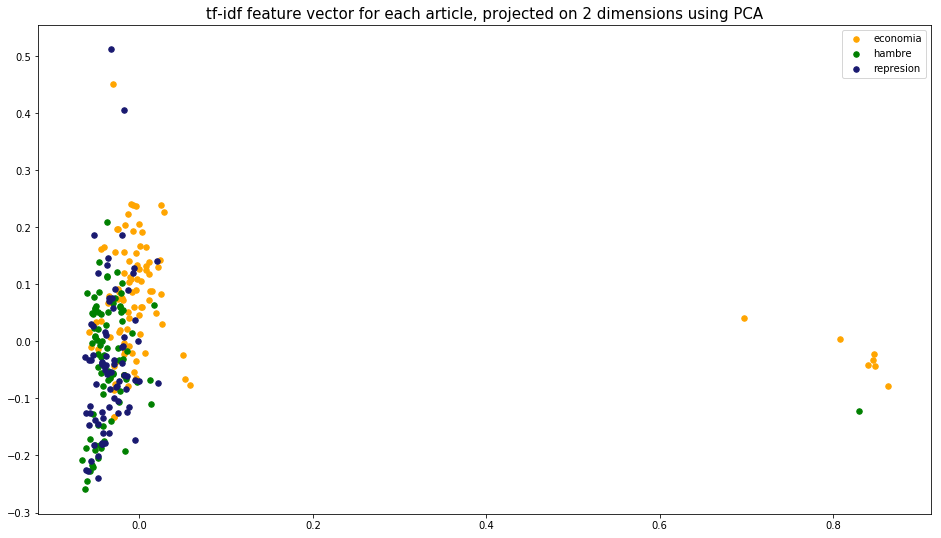

In [49]:
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(30)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = PCA(n_components=2, random_state=3000).fit_transform(features[indices])
colors = ['green', 'midnightblue', 'orange']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions using PCA",
          fontdict=dict(fontsize=15))
plt.legend()

En este gráfico apreciamos que al proyectar el vector de cada documento coloreado por su categoría, PCA genera puntos que no están separados en 2 dimensiones, sin embargo, si observamos los datos parecen estar superpuestos en las primeras dos componentes principales, por lo que es posible una separación.

### Comparación de modelos

Vamos a comparar varios modelos, utilizando las funcionalidades que tiene sklearn.

Nótese que estamos comparando modelos utilizando 5-fold cross validation.

LinearSVC: Escogí este modelo ya que se adapta bastante bien a los outliers, y no tiene problemas con altas dimensionalidades.

MultinomialNB: Naive Bayes como línea de accuracy mínima.

LogisticRegression: Ya que TF-IDF está normalizado con L2 normalization, los valores son probabilidades, adecuados para regresión logística.

RandomForest: Darle una oportunidad a un Ensemble.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    LinearSVC()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

Aquí tomaremos los resultados acumulados del cross validation para graficar box plots

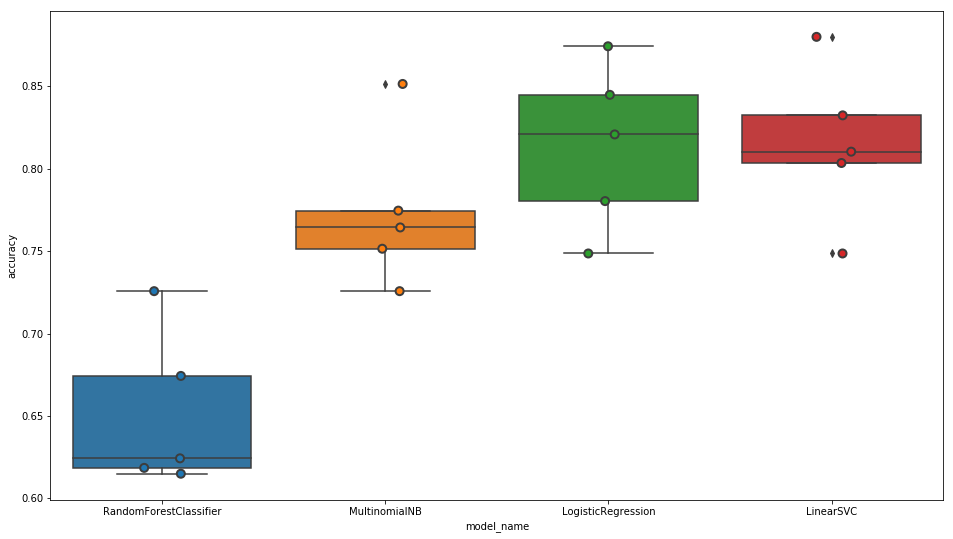

In [50]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

Aquí tomamos la mediana de los resultados del 5-fold crossvalidation

In [41]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.814951
LogisticRegression        0.813768
MultinomialNB             0.773504
RandomForestClassifier    0.651543
Name: accuracy, dtype: float64

Se puede observar que regresión logística logra un accuracy del 81%, junto con SVM lineal.

In [42]:
model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

Aquí vamos a graficar una matriz de confusión, para entender cómo se equivocó LogisticRegression

Text(0.5,60,'Predicted')

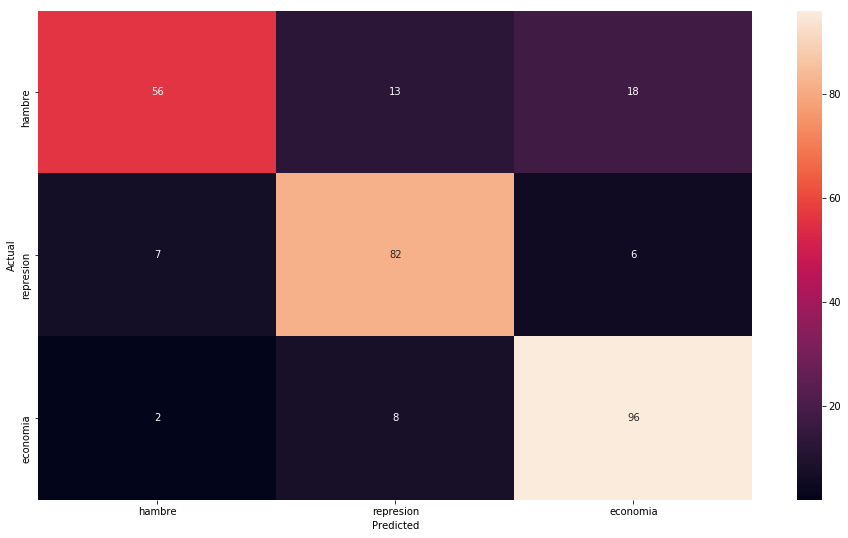

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Este pequeño código hace sencillo ver las noticias mal clasificadas

In [44]:
lista_misclassified = []
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 2:
            string_mispred = "'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted])
            print(string_mispred)
            mispredicted = data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]
            lista_misclassified.append({"actual": id_to_category[actual],"predicted": id_to_category[predicted], "points": mispredicted})
            display(mispredicted[['title', 'texto','url']])
            print('')

'represion' predicted as 'hambre' : 7 examples.


,title,texto,url
466,Saqueos y represión en Zulia,Diario Ámbito Financiero\nTel: 4349-1500 - Pas...,https://www.ambito.com/saqueos-y-represion-zul...
343,«Entraron en mi casa con armas. Me fui de Vene...,"Este sitio web puede utilizar algunas ""cookies...",https://www.diaridetarragona.com/tarragona/Ent...
279,Crisis en Venezuela: tras una jornada de prote...,Miembro de GDA. Grupo de Diarios América\nProt...,https://www.lanacion.com.ar/2213895-crisis-ven...
519,"Venezuela: cuatro muertos, represión y una est...",Miembro de GDA. Grupo de Diarios América\nProt...,https://www.lanacion.com.ar/2213520-venezuela-...
424,"Maduro sobrevive, Venezuela agoniza","Consulta la portada de EL PAÍS, Edición Améric...",https://elpais.com/internacional/2018/07/28/ac...
379,"Colette Capriles, filósofa venezolana: Chavism...",La filósofa venezolana Colette Capriles es pro...,https://www.laprensa.com.ni/2019/02/18/politic...
384,Luis Ortiz: Maduro dirige una narcotiranía con...,JMF: ¿Cómo está ahora Venezuela?\nLuis Ortiz: ...,https://intereconomia.com/tendencias/luis-orti...



'economia' predicted as 'hambre' : 2 examples.


,title,texto,url
624,La eterna adolescencia de sobrevivir en Venezuela,Casi como aprender a manejarse de cero cada ma...,https://gestion.pe/economia/eterna-adolescenci...
541,Venezuela cierra frontera clave por mar y aire...,(CNN) — Venezuela cerró una frontera marítima ...,https://cnnespanol.cnn.com/2019/02/20/venezuel...



'hambre' predicted as 'represion' : 13 examples.


,title,texto,url
38,Publinews Guatemala,Opositores marcharon este martes en varias ciu...,https://www.publinews.gt/gt/noticias/2019/02/1...
70,ARZOBISPO DE VENEZUELA: EL PUEBLO TIENE HAMBRE...,Mons. José Luis Azuaje / Crédito: Conferencia ...,http://vida-nueva.com/arzobispo-venezuela-pueb...
20,Amnistía Internacional acusó al régimen de Mad...,Amnistía Internacional (AI) responsabilizó est...,https://www.infobae.com/america/venezuela/2019...
19,Informe de Amnistía Internacional: en Venezuel...,"“Venezuela: Hambre, castigo y miedo, la fórmul...",https://www.cambio16.com/informe-de-amnistia-i...
37,Radio Agricultura,Opositores marchaban este martes en varias ciu...,https://www.radioagricultura.cl/internacional/...
244,La contundente carta de Mons. Mario Moronta a ...,La iglesia en Venezuela también se ha visto af...,http://www.venezuelaaldia.com/2019/02/18/la-co...
44,Arzobispo de Venezuela: El pueblo tiene hambre...,El Presidente de la Conferencia Episcopal de V...,https://www.aciprensa.com/noticias/arzobispo-d...
139,"Juan Guaidó, presidente de la Asamblea Naciona...","“¡Eres un usurpador! Nicolás, el 10 este Parla...",https://www.latercera.com/mundo/noticia/jaime-...
61,Periodista alemán preso en Venezuela por fotog...,"Redacción de CiberCuba Mié, 06/02/2019 - 9:10p...",https://www.cibercuba.com/noticias/2019-02-06-...
249,Periodista alemán detenido en Venezuela desde ...,*Esta nota ha sido actualizada a las 7:21P.M. ...,https://knightcenter.utexas.edu/es/blog/00-205...



'economia' predicted as 'represion' : 8 examples.


,title,texto,url
650,Los obispos apoyan la postura de Francisco sob...,"Estimado lector, muchas gracias por su interés...",https://www.eldia.com/nota/2019-2-5-3-1-31-los...
651,Pedro Sánchez reconoce a Guaidó como president...,"El presidente del Gobierno, Pedro Sánchez, ha ...",https://cincodias.elpais.com/cincodias/2019/02...
813,Cómo Venezuela ha llegado hasta aquí (III: el ...,¿Es moralmente lícito matar al tirano?\nEsta p...,https://infovaticana.com/blogs/teologia-econom...
824,"Muro fronterizo, inmigración, economía y crisi...",Univision6 Feb 2019 – 11:40 PM EST,https://www.univision.com/shows/noticiero-univ...
661,Reactivar la negociación: necesidad de una Nic...,<!--\r\n\t\t\t dows = new A...,https://elmundo.sv/reactivar-la-negociacion-ne...
844,Juan Guaidó presentó el 'Plan País' que reacti...,"""Tengo cáncer terminal en etapa 4 y no hay for...",https://www.am.com.mx/2019/02/01/mundo/juan-gu...
632,Guerra sostiene que EEUU evitó injerirse en la...,Si inicias sesión aceptas nuestra política de ...,https://www.publico.es/internacional/guerra-di...
563,AméricaEconomía.com,Caracas. Durante un acto de graduación de médi...,https://www.americaeconomia.com/politica-socie...



'hambre' predicted as 'economia' : 18 examples.


,title,texto,url
64,Cambian bolívares por pesos a beneficio de niñ...,Chihuahua.- Derivada de la crisis humanitaria ...,http://laopcion.com.mx/noticia/228838
97,"Nicolás Maduro en lujoso restaurante, mientras...","El presidente de Venezuela, Nicolás Maduro, fu...",https://www.excelsior.com.mx/global/nicolas-ma...
69,Venezuela tiene hambre,Venezuela tiene hambre; aparte de las ansiedad...,https://cadenaser.com/programa/2019/01/24/hora...
35,Jacobo Torres de León: En Venezuela no nos est...,ND / 19 feb 2019.- El representante de la Cent...,http://www.noticierodigital.com/2019/02/jacobo...
152,Hasta la FAO deja en ridículo a Errejón,,https://www.libremercado.com/2018-11-13/hasta-...
92,La Venezuela profunda recurre a la siembra par...,,https://www.abc.es/internacional/abci-venezuel...
186,"Venezuela, cuando el hambre y la pobreza se co...",Un vendedor espera en la oscuridad dentro de u...,https://www.elespanol.com/mundo/america/201712...
134,Ganar con el hambre en Venezuela,Una empresa fantasma con sede en Sabadell (Bar...,https://elpais.com/politica/2018/03/17/actuali...
60,Niño venezolano relata la difícil situación en...,,https://noticias.canalrcn.com/nacional-regione...
49,"Venezuela 2019, la refundación de la nación",La opinión de\n Froilán Barrios...,http://www.el-nacional.com/noticias/columnista...



'represion' predicted as 'economia' : 6 examples.


,title,texto,url
306,Crisis en Venezuela: por qué la incertidumbre ...,Comparte esta actualización en\nEstos son vínc...,https://www.bbc.com/mundo/noticias-america-lat...
324,Estados Unidos sanciona a funcionarios de la c...,La batería de sanciones de Estados Unidos cont...,https://elpais.com/internacional/2019/02/15/ac...
349,Corto documental Nunca Jamás en Venezuela: Her...,,https://www.infobae.com/america/venezuela/b0dd...
299,La represión de las protestas se ha segmentado...,Grupo La Provincia cumple quince años con una ...,https://www.grupolaprovincia.com/internacional...
363,"Nicolás Maduro: ""Jamás ha habido ni habrá repr...",Comparte esta actualización en\nEstos son vínc...,https://www.bbc.com/mundo/noticias-47215367
316,Puntallana condena “la represión” del régimen ...,Twitter\n \n \n Facebook\...,https://www.eldiario.es/canariasahora/lapalmaa...


Como se puede observar, en estos ejemplos pareciera que una clasificación multinomial (cada noticia pertenece a una sola categoría.) es poco acertada, por lo que dejamos al lector para que decida.

In [57]:
# Sacar unos ejemplos para el Paper
print(lista_misclassified[-1])
print(lista_misclassified[-1]["points"])
lista_misclassified[-1]["points"]["url"][306]


{'actual': 'represion', 'predicted': 'economia', 'points':                          fecha  strategy  \
306                 12/06/0000         2   
324  2019-02-16T10:07:23+01:00         1   
349                       None         2   
299                       None         2   
363                 12/06/0000         2   
316  2019-02-01T13:00:34+01:00         1   

                                                 texto  \
306  Comparte esta actualización en\nEstos son vínc...   
324  La batería de sanciones de Estados Unidos cont...   
349                                                      
299  Grupo La Provincia cumple quince años con una ...   
363  Comparte esta actualización en\nEstos son vínc...   
316  Twitter\n        \n        \n        Facebook\...   

                                                 title  \
306  Crisis en Venezuela: por qué la incertidumbre ...   
324  Estados Unidos sanciona a funcionarios de la c...   
349  Corto documental Nunca Jamás en Venezuela: Her

'https://www.bbc.com/mundo/noticias-america-latina-47170209'

In [46]:
misclassified.head()

NameError: name 'misclassified' is not defined